<a href="https://colab.research.google.com/github/supai-red/DS-Unit-2-Regression-Classification/blob/master/DS7_213_Andrea_Christelle__assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
pd.options.display.float_format = '{:,}'.format
df['SALE_PRICE'].head()
df['SALE_PRICE'].tail()

23035     510000
23036     355000
23037     375000
23038    1100000
23039     569202
Name: SALE_PRICE, dtype: int64

In [0]:
print(df.shape)
df.head()

(23040, 21)


BOROUGH             NEIGHBORHOOD  ... SALE_PRICE   SALE_DATE
0        1                  CHELSEA  ...          0  01/01/2019
1        1                  FASHION  ...          0  01/01/2019
2        1                  FASHION  ...          0  01/01/2019
3        1   GREENWICH VILLAGE-WEST  ...          0  01/01/2019
4        1  UPPER EAST SIDE (59-79)  ...          0  01/01/2019

[5 rows x 21 columns]

In [0]:
import numpy as np
import pandas as pd

#General steps to remove outliers
#Removing most extreme 1% of prices
#Removing most extreme .1% latitudes and longitudes

df = df[(df['SALE_PRICE'] >= np.percentile(df['SALE_PRICE'], 0.5)) & 
        (df['SALE_PRICE'] <= np.percentile(df['SALE_PRICE'], 99.5))]

#Note that with more time I would go through and elminate zero prices and look 
#at outliers more carefully. 

In [0]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
#Convert SALE DATE number format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
df['SALE_DATE'].dtype

dtype('<M8[ns]')

###Use a subset of the data
BUILDING_CLASS_CATGORY=='01 ONE FAMILY DWELLINGS'
SALE_PRICE more than 100,000
SALE_PRICE less than 2,000,000

In [0]:
mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
  (df['SALE_PRICE'] > 100000) &
  (df['SALE_PRICE'] < 2000000))

df = df[mask]

###Do train/test split
Use data from January - March 2019 to train. Use data from April 2019 to test.

In [0]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape    

((2507, 21), (644, 21))

Now that I have the data I want to work with, narrowed by sales price, and divided into train/test by date, I can run pandas profiling.

In [0]:
import pandas_profiling
train.profile_report()

### Do exploratory visualizations with Seaborn

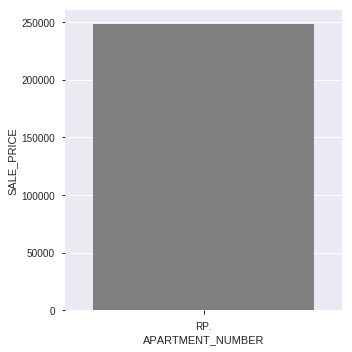

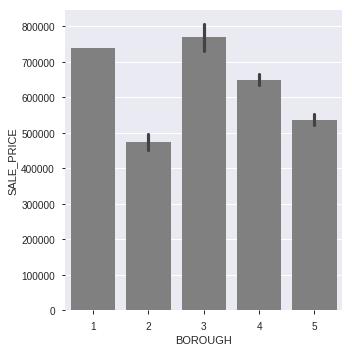

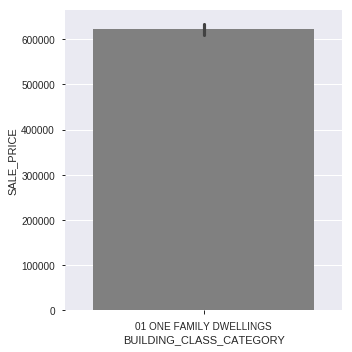

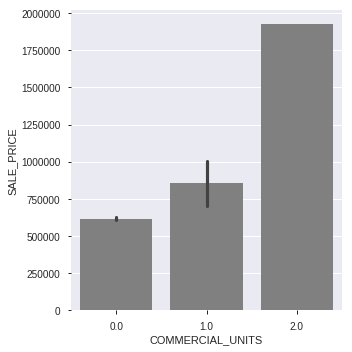

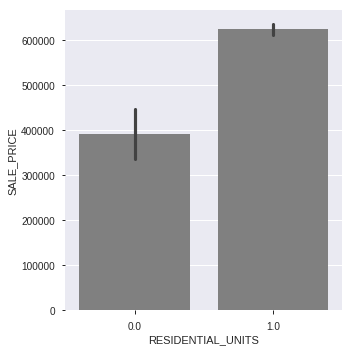

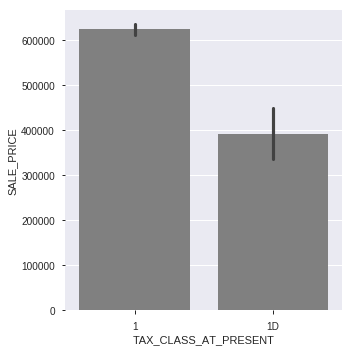

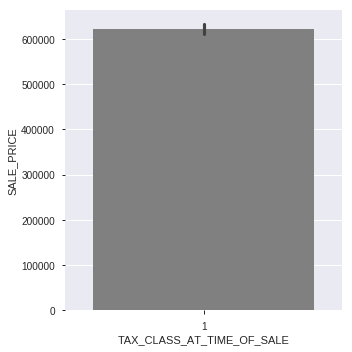

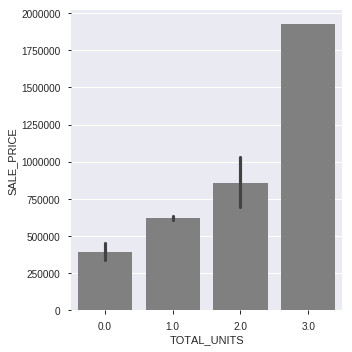

In [0]:
#Not sure about nunique here

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

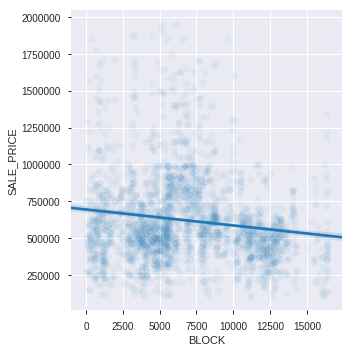

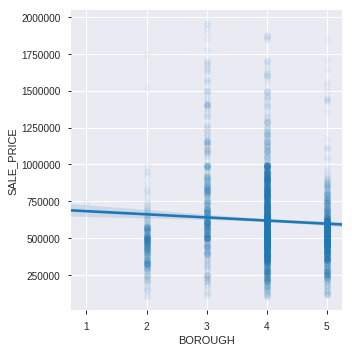

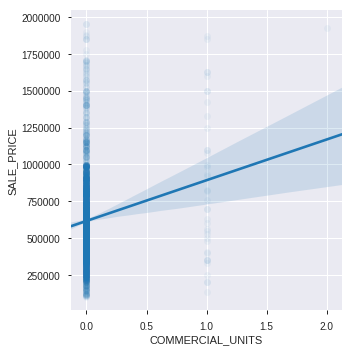

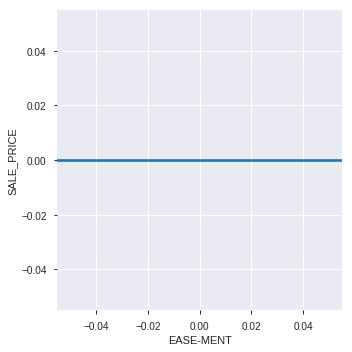

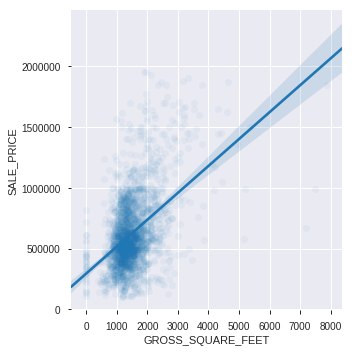

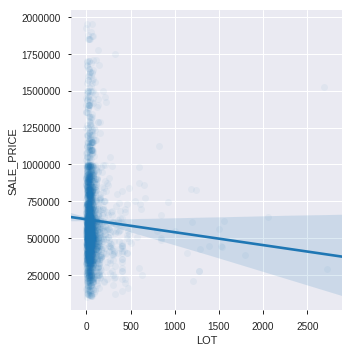

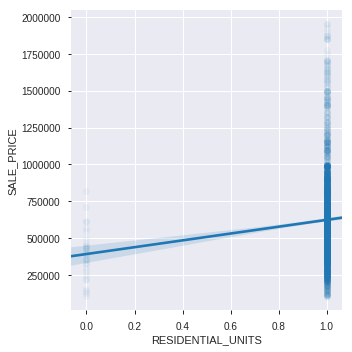

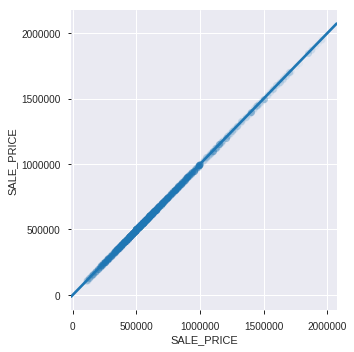

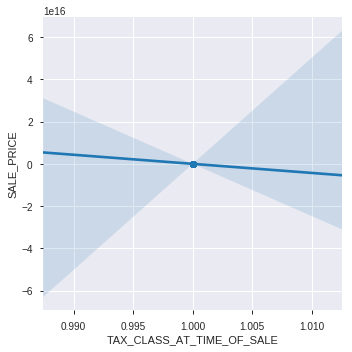

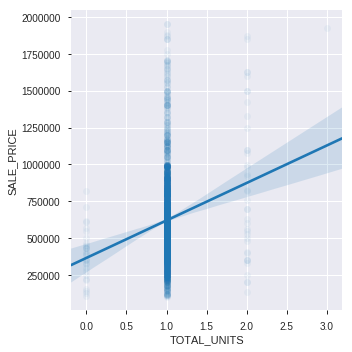

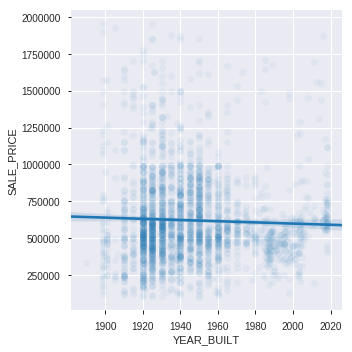

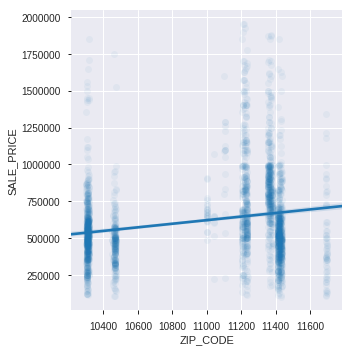

In [0]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
   sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
   plt.show()

###Do one-hot encoding of categorical features
Borough is a numeric column, but arguably should be a categorical feature,
so convert it from a number to a string



In [0]:
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)
test['BOROUGH'].dtypes

In [0]:
#Check cardinality of non-numeric features
train.describe(exclude='number').T.sort_values(by='unique')

count  ...                 last
BUILDING_CLASS_CATEGORY         2507  ...                  NaN
APARTMENT_NUMBER                   1  ...                  NaN
TAX_CLASS_AT_PRESENT            2507  ...                  NaN
BOROUGH                         2507  ...                  NaN
BUILDING_CLASS_AT_TIME_OF_SALE  2507  ...                  NaN
BUILDING_CLASS_AT_PRESENT       2507  ...                  NaN
SALE_DATE                       2507  ...  2019-03-30 00:00:00
NEIGHBORHOOD                    2507  ...                  NaN
LAND_SQUARE_FEET                2507  ...                  NaN
ADDRESS                         2507  ...                  NaN

[10 rows x 6 columns]

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

train['NEIGHBORHOOD'].value_counts()

#That put a lot into the other category. 

OTHER                       1908
FLUSHING-NORTH                77
GREAT KILLS                   69
ST. ALBANS                    66
SPRINGFIELD GARDENS           66
QUEENS VILLAGE                64
SO. JAMAICA-BAISLEY PARK      64
SOUTH OZONE PARK              49
MIDLAND BEACH                 48
BAYSIDE                       48
LAURELTON                     48
Name: NEIGHBORHOOD, dtype: int64

In [0]:
target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number')